# Attribution scores Statistics

In this notebook we retrieve attribution scores statistics and analyze our hypothesis using significance testings.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.dirname(os.path.dirname(os.path.abspath(os.path.join('.'))))
if module_path not in sys.path:
    print('Add root path to system path: ', module_path)
    sys.path.append(module_path)
module_path += '/'

Add root path to system path:  D:\Projets\Georgia Tech\Comp Social Science\cs6471-project


In [3]:
import re
import gc
import tqdm
import argparse
import numpy as np
import datetime
import time

import spacy
import pandas as pd
from sklearn.metrics import f1_score

from torch import optim
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from src.utils.preprocess_utils import *
from src.training.train_utils import train_model, test_model
from src.evaluation.test_save_stats import *

from src.utils.utils import *
from src.evaluation.xai_utils import *
from src.evaluation.xai_bert_utils import BertModelWrapper

import captum
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization, IntegratedGradients

from typing import Any, Iterable, List, Tuple, Union
from IPython.core.display import HTML, display

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Richard\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Initialization

### ⚠️ Before running the cells below, make sure to run :

- test_save_stats.py --model=MODEL_NAME--saved_model_path=PATH_TO_MODEL (see source code for more details) + any model parameters needed

The code saves the samples for which the model is sure of its prediction (ie. when it the probability is either really close to 1 (Hate) or close to 0 (Neutral)). <br>
We are now going to visualize the explainability of the model (ie. the importance of words in the model's decision) respectively for True Positives (TP), False Positives (FP), True Negatives (TN) and False Negatives(FN).

**Choose your configuration here for the attribution statistics retrieval**

```python
# Your model type (Currently only BERT is supported)
model_type = 'DistillBert'


# Dataset to retrieve stats from
## OffensEval
test_dataset_name = 'offenseval'

## Implicit Hate
test_dataset_name = 'implicithate'

## Covid Hate
test_dataset_name = 'covidhate'


# Models weights and test inference stats
## Trained on OffensEval
saved_model_path = module_path + SAVED_MODELS_PATH + 'DistillBert_2022-04-15_02-48-34_trained_testAcc=0.8026.pth'
stats_path = module_path + STATS_CSV + "stats_DistillBert_2022-04-15_02-48-34_test_crossentropy_offenseval.csv"

## Trained on Implicit Hate
saved_model_path = module_path + SAVED_MODELS_PATH + 'DistillBert_2022-04-18_02-48-16_trained_testAcc=0.7585.pth'
stats_path = module_path + STATS_CSV + "stats_DistillBert_2022-04-18_02-48-16_test_crossentropy_implicithate.csv"

## Trained on Covid Hate
saved_model_path = module_path + SAVED_MODELS_PATH + 'DistillBert_2022-04-18_02-24-40_trained_testAcc=0.8397.pth'
stats_path = module_path + STATS_CSV + "stats_DistillBert_2022-04-18_02-24-40_test_crossentropy_covidhate.csv"
```

In [4]:
# Your model type
model_type = 'DistillBert'

# Dataset to retrieve stats from
test_dataset_name = 'offenseval'

# Models weights and test inference stats
saved_model_path = module_path + SAVED_MODELS_PATH + 'DistillBert_2022-04-18_02-24-40_trained_testAcc=0.8397.pth'
stats_path = module_path + STATS_CSV + "stats_DistillBert_2022-04-18_02-24-40_test_crossentropy_covidhate.csv"

⚠️ When retrieving attribution scores stats, the saved pkl file is quite big (~313 Mo for offenseval, ~880 Mo for implicithate and ~170 Mo for covidhate), please use `IN_PLACE = True` to not save the pkl file and do all the operations in-place ⚠️

In [5]:
# Stats retrieval parameters
IN_PLACE = False # Does not save pkl file

# Path to attrib stats
attrib_stats_pkl_path = '_'.join(re.split('_', stats_path)[:-1]) + '_' + test_dataset_name + '.pkl'
stats_exists = os.path.exists(attrib_stats_pkl_path)
print(attrib_stats_pkl_path)
print('Stats already exists', stats_exists)
print('IN_PLACE', IN_PLACE)

# Skip attribution stats retrieval process if .pkl exists
SKIP_RETRIEVAL = stats_exists and not IN_PLACE
print('Skipping the stats retrieval:', SKIP_RETRIEVAL)

# Specific other parameters
fix_length = None

D:\Projets\Georgia Tech\Comp Social Science\cs6471-project/stats-results/stats_DistillBert_2022-04-18_02-24-40_test_crossentropy_offenseval.pkl
Stats already exists True
IN_PLACE False
Skipping the stats retrieval: True


In [6]:
dict_model_id_training_set = {'2022-04-15_02-48-34': 'offenseval', 
                              '2022-04-18_02-48-16': 'implicithate', 
                              '2022-04-18_02-24-40': 'covidhate'}

# Get model_id
model_id = get_model_id_from_path(saved_model_path)
print('Model trained on', dict_model_id_training_set[model_id])

if not SKIP_RETRIEVAL:
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print("Device:", device)

    field, tokenizer, _, _, _ = get_datasets(test_dataset_name, test_dataset_name, model_type, fix_length, 
                                             module_path=module_path)

    print("Loading vocabulary...")
    vocab_stoi, vocab_itos = get_vocab_stoi_itos(field)
    print("Vocabulary Loaded")

model_id: 2022-04-18_02-24-40
Model trained on covidhate


In [7]:
if not SKIP_RETRIEVAL:
    print("Loading Model...")
    model = load_model(model_type, field, device)
    model = load_trained_model(model, saved_model_path, device)
    print("Model Loaded.")

In [8]:
print("Loading Stats Data..")
df = pd.read_csv(stats_path)
df = df.drop(columns=["Unnamed: 0"])
print(df.shape)
df.head()

Loading Stats Data..
(458, 6)


,original_index,text,true_label,pred_label,prob,loss
0,0,[CLS] @ liangxiongjie @ prettylieb @ brandonda...,1,1,0.994429,0.005587
1,1,[CLS] all these people shouting boycottryanair...,0,0,0.001641,0.001642
2,2,[CLS] fangbin took a camera & amp ; filmed the...,0,0,0.027560,0.027947
3,3,"[CLS] "" w. h. o. : there's coronavirus in your...",0,1,0.965641,3.370900
4,4,[CLS] @ big _ crusher1000 @ lynda63986855 @ sh...,0,0,0.004000,0.004008


## Initialization of Integrated Gradients

In [9]:
if not SKIP_RETRIEVAL:
    bert_model_wrapper = BertModelWrapper(model).to(device)
    ig = IntegratedGradients(bert_model_wrapper)

## Statistics on Attribution scores

In [10]:
import pickle

from scipy import stats as scipy_stats

from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

import seaborn as sns

from xai_bert_utils import model_explainability_bert_with_stats, process_attributions_stats

In [11]:
%%time

if not SKIP_RETRIEVAL:
    max_samples = len(df)
    stats = model_explainability_bert_with_stats(bert_model_wrapper, tokenizer, ig, df,\
                                                 max_samples, device)

    if not IN_PLACE:
        with open(attrib_stats_pkl_path, 'wb') as f:
            pickle.dump(stats, f)
else:
    with open(attrib_stats_pkl_path, 'rb') as f:
        stats = pickle.load(f)

print('length stats', len(stats))

length stats 860
Wall time: 1.41 s


In [12]:
%%time
dict_word_attributions = {}
dict_attrib_stats = {'original_idx': [], 
                     'label': [],
                     'pred': [], 
                     'pred_ind': [],
                     'attributions': [],}

for stat in stats:
    attributions_ig, delta, tokens, input_ids, input_embedding, pred, pred_ind, label, original_idx = stat
    attributions = process_attributions_stats(attributions_ig)

    for idx in range(len(tokens)):
        word = tokens[idx]
        attribution = attributions[idx]
        if word not in dict_word_attributions:
            dict_word_attributions[word] = [attribution]
        else:
            dict_word_attributions[word] += [attribution]

    dict_attrib_stats['original_idx'].append(original_idx)
    dict_attrib_stats['label'].append(label)
    dict_attrib_stats['pred'].append(pred)
    dict_attrib_stats['pred_ind'].append(pred_ind)
    dict_attrib_stats['attributions'].append(np.mean(attributions))

Wall time: 2.44 s


### Word cloud of of attributions scores

In [13]:
from wordcloud import WordCloud, STOPWORDS

In [14]:
def plot_wordcloud_attribution(attrib_words, invert=False, width=800, height=800, min_font_size=8, save_fig_path=''):
    comment_words = ''
    stopwords = set(STOPWORDS)
    inverted = -1 if invert else 1

    for word, val in attrib_words:
        new_word = (word + ' ') * int(val*100 * inverted)
        comment_words += new_word

    wordcloud = WordCloud(width=width, height=height,
                    background_color='white',
                    stopwords=stopwords,
                    min_font_size=min_font_size, collocations=False).generate(comment_words)

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    if len(save_fig_path) > 0: plt.savefig(save_fig_path)
    plt.show()

In [15]:
dict_word_attributions_mean = {}
for word in dict_word_attributions:
    dict_word_attributions_mean[word] = np.mean(dict_word_attributions[word])
attrib_words = dict_word_attributions_mean.items()

[('taste', 0.5906339340742663), ('fucking', 0.589697202191185), ('cia', 0.548670524246923), ('fuck', 0.4975793771160615), ('dong', 0.450601745130867), ('##ming', 0.4208381263451707), ('##eno', 0.38503181552346505), ('fi', 0.3496802665772934), ('##rse', 0.3264111176382594), ('phil', 0.3248156689432597)]


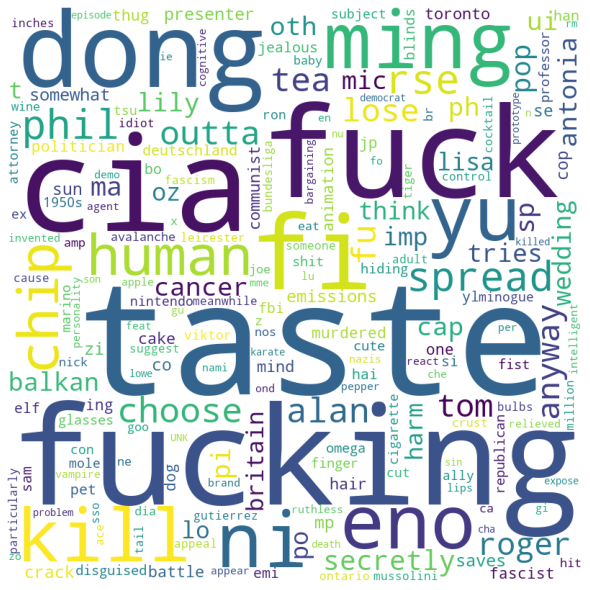

In [16]:
# Highest attribution scores
high_attrib_words = sorted(attrib_words, reverse=True, key=lambda x: x[1])[:10]
print(high_attrib_words)

# Plot wordcloud
save_fig_path = module_path + FIGURES_PATH + 'high_attrib_wordcloud_{}_{}_{}.png'.format(model_id, 
                                                                                     dict_model_id_training_set[model_id], 
                                                                                     test_dataset_name)
plot_wordcloud_attribution(attrib_words, save_fig_path=save_fig_path)

[('accomplishment', -0.7368402759100321), ('[SEP]', -0.6462047877900636), ('##ads', -0.6360545245529382), ('##ticus', -0.5430265275160613), ('awe', -0.5354271857939892), ('nueva', -0.5130254478353787), ('follows', -0.48293290956732454), ('referendum', -0.466608899820457), ('pants', -0.4136565144131343), ('rb', -0.41212050259862776)]


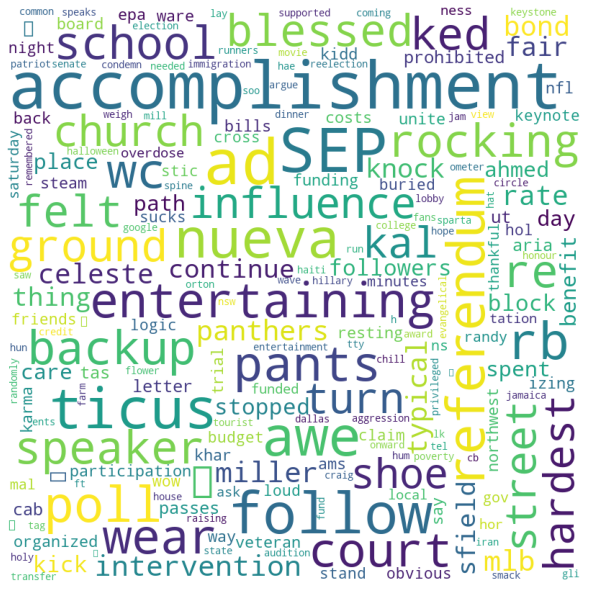

In [17]:
# Lowest attribution scores
low_attrib_words = sorted(attrib_words, reverse=False, key=lambda x: x[1])[:10]
print(low_attrib_words)

# Plot wordcloud
save_fig_path = module_path + FIGURES_PATH + 'low_attrib_wordcloud_{}_{}_{}.png'.format(model_id, 
                                                                                     dict_model_id_training_set[model_id], 
                                                                                     test_dataset_name)
plot_wordcloud_attribution(attrib_words, invert=True, save_fig_path=save_fig_path)

## Attributions per instances

In [18]:
df_attrib_stats = pd.DataFrame.from_dict(dict_attrib_stats)
df_attrib_stats

,original_idx,label,pred,pred_ind,attributions
0,0,1,0.002117,0,-0.013724
1,1,0,0.004216,0,-0.055107
2,2,0,0.001789,0,-0.034937
3,3,0,0.001536,0,-0.037395
4,4,1,0.010822,0,-0.034057
...,...,...,...,...,...
855,855,1,0.001875,0,-0.032665
856,856,0,0.002129,0,-0.021588
857,857,1,0.002246,0,-0.021680
858,858,0,0.001878,0,-0.019695


In [19]:
non_hate_attrib_stats = df_attrib_stats.loc[df_attrib_stats['label'] == 0]['attributions']
hate_attrib_stats = df_attrib_stats.loc[df_attrib_stats['label'] == 1]['attributions']

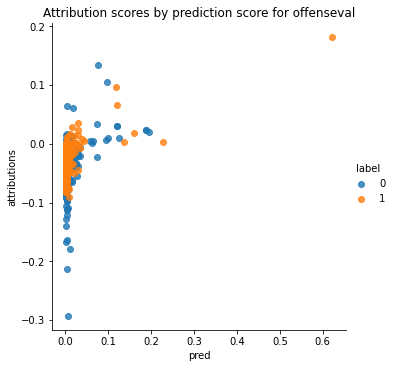

r, pvalue between pred and attributions 0.1748 2.4758785012804194e-07


In [20]:
save_fig_path = module_path + FIGURES_PATH + 'attrib_pred_plot_{}_{}.png'.format(model_id, test_dataset_name)
sns.lmplot(x='pred', y='attributions', data=df_attrib_stats, hue='label', fit_reg=False)
plt.title('Attribution scores by prediction score for {}'.format(test_dataset_name))
plt.savefig(save_fig_path)
plt.show()

r, pvalue = scipy_stats.spearmanr(df_attrib_stats['pred'], df_attrib_stats['attributions'])
print('r, pvalue between pred and attributions', round(r, 4), pvalue)

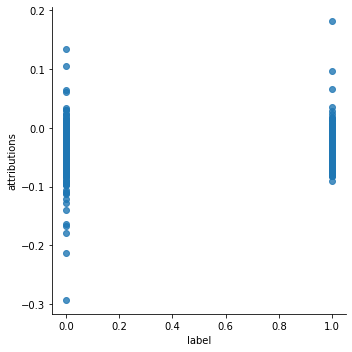

r, pvalue between label and attributions 0.0697 0.04110307062703777


In [21]:
sns.lmplot(x='label', y='attributions', data=df_attrib_stats, fit_reg=False)
plt.show()

r, pvalue = scipy_stats.spearmanr(df_attrib_stats['label'], df_attrib_stats['attributions'])
print('r, pvalue between label and attributions', round(r, 4), pvalue)

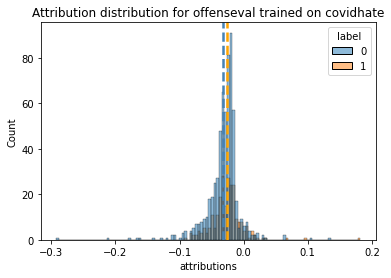

In [22]:
save_fig_path = module_path + FIGURES_PATH + 'attrib_distribution_{}_{}_{}.png'.format(model_id, 
                                                                                       dict_model_id_training_set[model_id], 
                                                                                       test_dataset_name)
sns.histplot(x='attributions', data=df_attrib_stats, hue='label')

# Vertical lines are the mean of the distributions
plt.axvline(x=non_hate_attrib_stats.mean(),
            color='steelblue',
            ls='--', 
            lw=2.5, label='Mean Non-Hate')
plt.axvline(x=hate_attrib_stats.mean(),
            color='orange',
            ls='--', 
            lw=2.5, label='Mean Non-Hate')
plt.title('Attribution distribution for {} trained on {}'.format(test_dataset_name, dict_model_id_training_set[model_id]))
plt.savefig(save_fig_path)
plt.show()

## Significance testings

In [23]:
pvalue_threshold = 0.001

### Normality tests

In [24]:
from scipy.stats import normaltest

In [25]:
print('Non hate attrib stats')
value, pvalue = normaltest(non_hate_attrib_stats)
print('value:', value, 'pvalue:', pvalue)
if pvalue >= pvalue_threshold:
    print('It is likely that non_hate_attrib_stats is normal')
else:
    print('It is unlikely that non_hate_attrib_stats is normal')

Non hate attrib stats
value: 358.9531374719314 pvalue: 1.1332260963050415e-78
It is unlikely that non_hate_attrib_stats is normal


In [26]:
print('Hate attrib stats')
value, pvalue = normaltest(hate_attrib_stats)
print('value:', value, 'pvalue:', pvalue)
if pvalue >= pvalue_threshold:
    print('It is likely that hate_attrib_stats is normal')
else:
    print('It is unlikely that hate_attrib_stats is normal')

Hate attrib stats
value: 162.06084748270735 pvalue: 6.440715306795656e-36
It is unlikely that hate_attrib_stats is normal


### Compare Means for Non-Gaussian data

In [27]:
from scipy.stats import ks_2samp

In [28]:
value, pvalue = ks_2samp(non_hate_attrib_stats, hate_attrib_stats)
print('value:', value, 'pvalue:', pvalue)
if pvalue > pvalue_threshold:
    print('Samples are likely drawn from the same distributions (fail to reject H0)')
else:
    print('Samples are likely drawn from different distributions (reject H0)')

value: 0.11827956989247312 pvalue: 0.014334663374726886
Samples are likely drawn from the same distributions (fail to reject H0)
